# 9. Blinking bacteria: The repressilator enables self-sustaining oscillations

<hr>

**Design principle**

- Ultrasensitive negative feedback can generate periodic oscillations in cells.
- Oscillator phase can be used as a growth timer.

**Techniques**

- Composition of functions
- Linear stability analysis
- Linear stability diagrams
- Numerical calculation of a scalar fixed point
- Synthetic biology

**References**

- [Elowitz & Leibler, A synthetic oscillatory network of transcriptional regulators, *Nature*, 2000](https://doi.org/10.1038/35002125)
- [Synchronous long-term oscillations in a synthetic gene circuit, *Nature*, 2016](https://doi.org/10.1038/nature19841) 

<hr>

In [1]:
# Colab setup ------------------
import os, sys, subprocess
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade biocircuits colorcet watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
# ------------------------------

import numpy as np
import scipy.integrate
import scipy.optimize

import biocircuits

import bokeh.plotting
import bokeh.io

import colorcet

# We will use Matplotlib to make a 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Set to True to have fully interactive plots with Python;
# Set to False to use pre-built JavaScript-based plots
interactive_python_plots = False
notebook_url = "localhost:8888"

bokeh.io.output_notebook()

Loading BokehJS ...

<hr>

## How to design a biological clock

In this chapter we will explore ways to build a clock in a living cell. More specifically, we will discuss a **synthetic genetic clock circuit** called the **Repressilator** ([Elowitz & Leibler, Nature, 2000](https://doi.org/10.1038/35002125)). We first discuss the  roles of oscillators and clocks in natural biological systems, and then ask how one might go about designing a synthetic clock circuit that can operate in a cell. To do this, we will use **linear stability analysis**, a broadly useful approach for analyzing diverse systems. We will also introduce the concept of a **limit cycle** attractor. 

### Clocks are necessary for life

Our lives depend on accurate time-keeping. This is enabled by generations of improvement in clocks. A major turning point in global navigation was the development of portable clocks, which enabled sailors to measure longitude. [John Harrison](https://en.wikipedia.org/wiki/John_Harrison) engineered a series of increasingly precise, and beautiful, clocks, or "marine chronometers." A big challenge was making them function accurately despite variations in temperature, humidity, and other conditions. To do this, he invented internal compensation mechanisms that made critical parameters robust to these conditions. Even today, navigation remains dependent on clocks. The Global Positioning System (GPS), which we use to navigate our cities, relies on precise atomic clocks installed in orbiting satellites. 

Time-keeping is as fundamental to our inner lives as it is to our outer lives. The cell division cycle drives the cell through a series of states, including periods of growth, chromosome replication, seperation of daughter cells, and so on. When cells are rapidly proliferating, this circuit acts as a kind of clock. Organisms also have **circadian clocks** that allow them to track and anticipate the daily environmental changes that occur during the 24 hour day. Plants have mechanisms to keep track of time on longer timescales, allowing them to anticipate seasonal changes. Hormones can cycle over timescales of weeks or months. On shorter timescales, some factors in the cell oscillate periodically in and out of the nucleus over timescales of minutes to hours. Countless processes in biology involve periodic cycles rather than steady states.


### Circadian clocks function in single cells

**Circadian clocks** control our 24 hour cycles of sleep, hunger, and activity. Humans confined to environments with constant light and temperature still maintain circadian activity cycles with [nearly 24hr periods](https://doi.org/10.1126/science.284.5423.2177)). This experiment, along with the more familiar experience of jet lag, shows that our body has an internal  clock that enforces temporal organization on our bodies and minds. The **cell cycle** represents another kind of oscillator that takes cells through repetitive cycles of growth and division. **Hormones** cycle on a range of timescales from hours to weeks. Plants contain circadian and **seasonal clocks** that control their movement and flowering, in response to time as well as light, temperature and other inputs. 

How do biological clocks work? In 1971, Ronald Konopka and Seymour Benzer [identified mutations that altered the circadian behavioral rhythms of fruit flies](https://doi.org/10.1073/pnas.68.9.2112). Over the next decades, biologists discovered key molecular components that enable these clocks to function, including transcription factors, light sensors, and other components, and worked out many aspects of the molecular mechanism of circadian oscillations. This work led to the [2017 nobel prize](https://www.nobelprize.org/prizes/medicine/2017/summary/) for Jeffrey Hall, Michael Rosbash, and Michael Young  "for their discoveries about how internal clocks and biological rhythms govern human life." 

In multicellular organisms, you might wonder whether the clock emerges from interactions among cells, or is controlled from within each cell. The answer seems to be both. Clocks synchronize between cells and organs. However, clocks are not solely a multicellular phenomenon: Individual mammalian fibroblasts exhibit free-running [circadian oscillations](https://doi.org/10.1016/0896-6273%2895%2990214-7), as one can see in [this movie](figs/independent_circadian_neurons.mov) from D. Welsh, et al. ([*Current Biology* 2004](https://doi.org/10.1016/j.cub.2004.11.057)). Circadian behavior here is revealed through expression of a luminescent reporter gene knocked into the mPer2 circadian clock gene. 

<div style="margin: auto; width: 350px;">

<video src="figs/independent_circadian_neurons.mov" style="width: 350px;" controls>Your browser does not support display of this video.</video>

</div>

Time traces of individual cells from this movie show periodic 24 hour oscillations:

<div style="width: 500px; margin: auto;">

![Welsh_circadian_single_cells_plotsonly_cropped](figs/Welsh_circadian_single_cells_plotsonly_cropped.png)

</div>

This work revealed a complex clock containing many interacting protein components. 

### In cyanobacteria, a three-protein phosphorylation circuit generates oscillations.

But clocks need not be complex. Even single cell cyanobacteria have precise, [cell-autonomous](https://doi.org/10.1038/nature02533) circadian clocks. To learn how they work, Kondo and colleagues genetically identified a single locus containing three genes required for the cyanobacterial clock. In 2005 they showed, amazingly, that these [three proteins, plus ATP,](https://doi.org/10.1126/science.1108451) were sufficient to reconstitute 24 hour oscillations of phosphorylation in a test tube. 

The mechanism for these oscillations was subsequently explained by Rust, et al. in terms of [ordered phosphorylation and feedback](https://doi.org/10.1126/science.1148596). One protein, KaiC, has two phosphorylation sites. During each cycle, one site is phosphorylated, then the second is phosphorylated, then the first is dephosphorylated, and finally the second is dephosphorylated. The use of two phosphorylation sites ensures the dynamics are at least two dimensional. A one dimensional dynamical system cannot oscillate (see Strogatz).

<!-- I would like to add a little more on the cyanobacterial clock circuit in the future -- but where should we insert it? --> 

## Limit cycles are ideal dynamical behaviors for clocks

So far in this course, we have discussed only one kind of "attractor"—the stable fixed point. When a system sits at a stable fixed point, it does not change over time. (While true for a continuous system, biological systems are made of discrete molecules whose dynamics are subject to stochastic fluctuations, or noise, and therefore they cannot really remain precisely at a single state. We will learn more about noise soon.) By contrast, in a functioning clock circuit, the state of the system constantly changes in a periodic fashion, progressing through a cyclic sequence of "phases" that returns it to its starting point. This cycling occurs on its own, without any  external input. Furthermore, if such an ideal clock circuit is perturbed in some way—whether by environmental fluctuations or internal noise—it returns to its oscillatory trajectory. It "has to" oscillate. 

The behavior we are describing is more formally known as a [**limit cycle**](https://en.wikipedia.org/wiki/Limit_cycle). Stable limit cycles are defined by [Strogatz](http://www.stevenstrogatz.com/books/nonlinear-dynamics-and-chaos-with-applications-to-physics-biology-chemistry-and-engineering) as "isolated closed orbits", meaning that the system goes around the limit cycle, and that neighboring points ultimately feed into the limit cycle. As a result, if the system is perturbed a little bit away from the limit cycle, it will tend to return back to it, as shown here:

<div style="width: 500px; margin: auto;">

![limit cycles](figs/limit_cycles.png)

</div>

Note that one can also have unstable limit cycles. 

As Strogatz notes, linear systems such as a frictionless pendulum can produce a family of orbits but not a limit cycle, because multiplying any solution of

\begin{align}
\frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t} =\mathsf{A} \cdot \mathbf{x}
\end{align}

by a constant produces another solution. Limit cycle oscillators are thus inherently non-linear systems.

For our purposes, the key point is that limit cycle dynamics are ideal for natural or synthetic clock circuits because they ensure periodic oscillations that do not damp out over time and can resume even if temporarily perturbed. 


## Build to understand: Designing a synthetic clock circuit

In biology, clocks have long been metaphorically identified with the perplexing mystery of how the undirected process of evolution could generate precise behaviors from seemingly "messy" molecular components. Dawkins's  1986 book, [The Blind Watchmaker](https://en.wikipedia.org/wiki/The_Blind_Watchmaker), personifies evolution as a watchmaker, who creates devices of astonishing precision (tissues and organisms) without being able to "see," much less plan, what she is doing. How "hard" is it for evolution—or anyone, really—to make a biological clock? 

We will now discuss the design of a synthetic clock circuit in bacteria. By seeing whether we can design a clock out of biological components, we can find out "how hard" it is to make a clock, what circuits are sufficient to produce self-sustaining **limit cycle** oscillations, and  whether the sorts of models we write down can describe biological circuits operating in the more complex, and largely uncharacterized, intracellular milieu. Beyond their value in teaching us about circuit design, synthetic clock circuits can also provide useful functions, as we will see below.

### Clock components should ideally be composable, orthogonal, and well-characterized 

The first question we must ask is what components we can build a clock from. Among the best characterized regulators in biology are prokaryotic (bacterial) transcriptional repressors and their cognate target promoters. These components are  **modular**, **orthogonal**, and **composable**. By modular, we mean that they can be taken out of their natural context and used to generate a new regulatory circuit. By orthogonal, we mean that a variety of variants exist that operate similarly, but independently. Thus, different repressors bind to distinct DNA binding sites. Composability is a stronger form of modularity in which a set of components can regulate each other in the  same way. LEGOs are a familiar example of composability: each of the standard bricks can be stuck onto a similar type of brick from below and above. Transcription factors are composable because any one can be engineered to regulate any other simply by combining corresponding target promoter sequences with open reading frames for the transcription factors. 

(Transcriptional activators, which we have already encountered, are also excellent components for synthetic design, and [have been used to build oscillators](https://doi.org/10.1038/nature07389). At the time this work was done, there were generally fewer examples that were as well-understood as repressors. Therefore, we will focus below on a circuit design built exclusively from repressors).


### Design strategy:

Based on the considerations above, we will try to design a biological circuit that generates **limit cycle oscillations** across a **broad range of biochemical parameter values** using a set of well-characterized, composable, and orthogonal **transcriptional repressors**. 

One of the first designs one can imagine building with repressors is a  "rock-scissors-paper" feedback loop composed of three repressors, each of which represses the next one, in a cycle:

<div style="width: 200px; margin: auto;">

![repressilator diagram](figs/simple_repressilator_diagram.png)

</div>


This diagram refers to three specific repressors, TetR, λ cI, and LacI. We will discuss the rationale for choosing these below, after we work out the design. For now, the names of the repressors are unimportant, so we will refer to them as repressors 1, 2, and 3. Repressor 1 represses production of repressor 2, which in turn represses production of repressor 3.  Finally, repressor 3 represses production or repressor 1, completing the loop.

<div style="width: 150px; margin: auto;">

![simple repressilator numbers](figs/simple_repressilator_numbers.png)

</div>


This design is a three-component negative feedback loop (analogous to a "three ring oscillator" in electronics). If one were to turn up the level of the first protein in this system, it would lead to a decrease in the second, which would cause an increase in the third, and finally a decrease in the first. Thus, one can see, intuitively, that this system produces a negative feedback that tends to push back in the opposite direction to any perturbation, after the delay required to propagate the perturbation around the loop. 

We can try to work out the dynamics of this system by intuitive reasoning. We might achieve a limit cycle oscillation: Say that repressor 1 is present at a high protein concentration, while repressors 2 and 3 are low. The high concentration of repressor 1 will limit expression of repressor 2, keeping its level low. This means that repressor 3 is free to be expressed.  As its concentration grows, it will start to repress repressor 1.  As repressor 1 goes down, repressor 2 is expressed in higher numbers.  The increased repressor 2 concentration leads to less repressor 3.  Then, repressor 1 comes back up again.  So, we see a cycle, where repressor 1 is high, then repressor 3, and finally repressor 2. 

However, this behavior is by no means guaranteed. We might equally well just get a stable steady state, where all three repressors evolve to intermediate values, each sufficient to keep its target repressor at the appropriate level to maintain its target at its steady-state level. This behavior would be much more boring. 

In fact, both behaviors are possible.

So, our questions are now: 

1. What kinds of behaviors would this circuit be expected to produce?
2. How can we engineer the circuit to favor, or better yet, guarantee, limit cycle oscillations?

## Dynamical equations for the repressilator

To analyze the repressilator, we will, as usual, write down a set of differential equations for each of the proteins. For simplicity, we will assume perfect symmetry among the species, with each one having identical biochemical properties (this will not be true in the real system). While we initially consider only protein dynamics here, later on, we will ask how including mRNA modifies the conclusions.

\begin{align}
\frac{\mathrm{d}x_1}{\mathrm{d}t} &= \frac{\beta}{1 + (x_3/k)^n} - \gamma x_1, \\[1em]
\frac{\mathrm{d}x_2}{\mathrm{d}t} &= \frac{\beta}{1 + (x_1/k)^n} - \gamma x_2, \\[1em]
\frac{\mathrm{d}x_3}{\mathrm{d}t} &= \frac{\beta}{1 + (x_2/k)^n} - \gamma x_3. 
\end{align}

In dimensionless units, we measure protein concentrations in units of $k$, the relevant protein concentration scale, and time in units of $\gamma^{-1}$, the only timescale in the system. With this, the equations become:

\begin{align}
\frac{\mathrm{d}x_i}{\mathrm{d}t} &= \frac{\beta}{1 + x_j^n} - x_i, \quad \text{ with } (i,j) \text{ pairs } (1,3), (2,1), (3,2).
\end{align}

Note that $\beta$ has been redefined as $\beta \leftarrow \beta/k\gamma$.

## Temporal dynamics

We can integrate the dynamical equations to follow the concentrations of three proteins over time. Interactive plotting further allows us to see how these dynamics depend on the parameters $\beta$ and $n$. Oscillations are clear when the curves go up and down periodically in time.

Alternatively, it is also instructive to plot the trajectory of the system as a projection in the $x_2$-$x_1$ plane (or in either of the other two planes this three-dimensional system can be projected onto). When the fixed point is stable, the trajectory in the $x_2$-$x_1$ plane spirals into the fixed point. When it is unstable, the trajectory spirals away from it, eventually cycling around the fixed point to join a limit cycle, corresponding to oscillations.

The layout below shows both plots. For sufficiently large $\beta$ and $n$, we see beautiful 3-phase oscillations. A few things to notice: 

* If $n<2$, oscillations diminish over time.
* If $n>2$, sustained oscillations occur, but only for large enough $\beta$
* If $n=2$, see what happens...

In [12]:
def protein_repressilator_rhs(x, t, beta, n):
    """
    Returns 3-array of (dx_1/dt, dx_2/dt, dx_3/dt)
    """
    x_1, x_2, x_3 = x

    return np.array(
        [
            beta / (1 + x_3 ** n) - x_1,
            beta / (1 + x_1 ** n) - x_2,
            beta / (1 + x_2 ** n) - x_3,
        ]
    )


# Initial condiations
x0 = np.array([1, 1, 1.2])

# Number of points to use in plots
n_points = 1000

# Widgets for controlling parameters
beta_slider_protein = bokeh.models.Slider(title="β", start=0, end=100, step=0.1, value=10)
n_slider_protein = bokeh.models.Slider(title="n", start=1, end=5, step=0.1, value=3)

# Solve for species concentrations
def _solve_protein_repressilator(beta, n, t_max):
    t = np.linspace(0, t_max, n_points)
    x = scipy.integrate.odeint(protein_repressilator_rhs, x0, t, args=(beta, n))

    return t, x.transpose()


# Obtain solution for plot
t, x = _solve_protein_repressilator(beta_slider_protein.value, n_slider_protein.value, 40.0)

# Build the plot
colors = colorcet.b_glasbey_category10[:3]

p_rep = bokeh.plotting.figure(
    frame_width=550, frame_height=200, x_axis_label="t", x_range=[0, 40.0]
)

cds = bokeh.models.ColumnDataSource(data=dict(t=t, x1=x[0], x2=x[1], x3=x[2]))
labels = dict(x1="x₁", x2="x₂", x3="x₃")
for color, x_val in zip(colors, labels):
    p_rep.line(
        source=cds,
        x="t",
        y=x_val,
        color=color,
        legend_label=labels[x_val],
        line_width=2,
    )

p_rep.legend.location = "top_left"


# Set up plot
p_phase = bokeh.plotting.figure(
    frame_width=200, frame_height=200, x_axis_label="x₁", y_axis_label="x₂",
)

p_phase.line(source=cds, x="x1", y="x2", line_width=2)

# Set up callbacks
def _callback(attr, old, new):
    t, x = _solve_protein_repressilator(beta_slider_protein.value, n_slider_protein.value, p_rep.x_range.end)
    cds.data = dict(t=t, x1=x[0], x2=x[1], x3=x[2])

    
beta_slider_protein.on_change("value", _callback)
n_slider_protein.on_change("value", _callback)
p_rep.x_range.on_change("end", _callback)

# Build layout
protein_repressilator_layout = bokeh.layouts.column(
    p_rep,
    bokeh.layouts.Spacer(height=10),
    bokeh.layouts.row(
        p_phase,
        bokeh.layouts.Spacer(width=70),
        bokeh.layouts.column(beta_slider_protein, n_slider_protein,width=150),
    ),
)

# Build the app
def protein_repressilator_app(doc):
    doc.add_root(protein_repressilator_layout)


# Display
if interactive_python_plots:
    bokeh.io.show(protein_repressilator_app, notebook_url=notebook_url)
else:
    bokeh.io.show(biocircuits.jsplots.protein_repressilator())

Finally, here is a simple three-dimensional plot of the limit cycle in the space of the three protein concentrations.

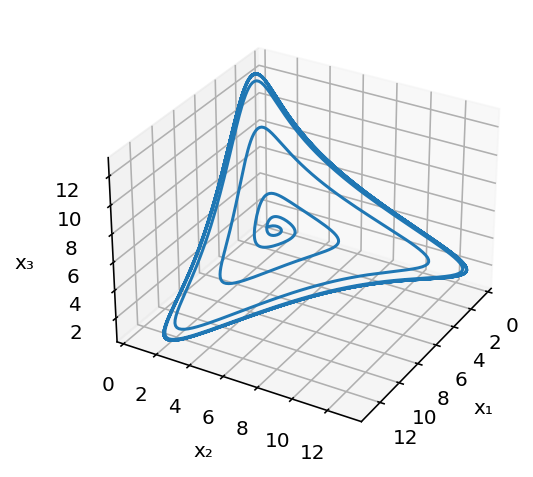

In [3]:
# Resolve problem for β = 20 and n = 3
t = np.linspace(0, 50, 1000)
x = scipy.integrate.odeint(protein_repressilator_rhs, x0, t, args=(20, 3))

# Generate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("x₃");

### What conditions are necessary and sufficient for oscillations?

Why does the system oscillate for some values of $n$ and $\beta$ but not others? To find out, we need to use linear stability analysis to see how the values of the key biochemical parameters, $\beta$ and $n$ control oscillations. 

As a first step, we will identify fixed points by solving $\mathrm{d}x_i/\mathrm{d}t = 0$ for each $x_i$. 

\begin{align}
&x_1 = \frac{\beta}{1+x_3^n}, \\[1em]
&x_2 = \frac{\beta}{1+x_1^n}, \\[1em]
&x_3 = \frac{\beta}{1+x_2^n}.
\end{align}

We can substitute the expression for $x_3$ into that for $x_1$ to get

\begin{align}
x_1 = \frac{\beta}{1 + \left(\displaystyle{\frac{\beta}{1 + x_2^n}}\right)^n}.
\end{align}

We can then substitute the expression for for $x_2$ to get

\begin{align}
x_1 = \frac{\beta}{1 + \displaystyle{\left(\frac{\beta}{1 + \left(\displaystyle{\frac{\beta}{1+x_1^n}}\right)^n}\right)^n}}.
\end{align}

This unwieldy expression can be written more conveniently as a **composition of functions**.  Specifically,

\begin{align}
x_1 = f(f(f(x_1))) \equiv f\!f\!f(x_1),
\end{align}

where
\begin{align}
f(x) = \frac{\beta}{1+x^n}.
\end{align}

By symmetry, this relation holds for repressors 2 and 3 as well, so we have

\begin{align}
x_i = f\!f\!f(x_i).
\end{align}

Writing the relationship for the fixed point with a composition of functions is useful because we can easily compute the derivatives of the composite function using the chain rule.

\begin{align}
(f\!f\,)'(x) &= f'(f(x))\cdot f'(x), \\[1em]
(f\!f\!f\,)'(x) &= f'(f\!f(x)) \cdot (f\!f\,)'(x) =  f'(f(f(x))) \cdot f'(f(x)) \cdot f'(x).
\end{align}

Now, since $f(x)$ is monotonically decreasing, $f'(x) < 0$, and also $f'(f(x)) < 0$.  This means that $f\!f'(x) > 0$, so $f\!f(x)$ is monotonically increasing. Now, $f'(f\!f(x)) < 0$, since $f'(\text{anything monotonically increasing}) < 0$. This means that $f\!f\!f(x)$ is monotonically decreasing.  Since $x_i$ is increasing, there is a single fixed point with $x = f\!f\!f(x)$. This is more clear if we look at a plot.

In [4]:
# Parameters
beta, n = 3, 2

# f(x)
f = lambda x: beta / (1 + x ** n)

# Make composition of functions
x = np.linspace(0, 3, 200)
fff = f(f(f(x)))

# Show plot
p = bokeh.plotting.figure(
    height=275, width=275, x_axis_label="x", x_range=[0, 3], y_range=[0, 3]
)
p.line(x, x, line_width=2, legend_label="x")
p.line(x, fff, line_width=2, color="orange", legend_label="fff(x)")
p.legend.location = "center_right"

bokeh.io.show(p)

Because the time derivative of $x_1$, $x_2$ and $x_3$ _all_ vanish at the fixed point, and we have shown that the fixed point is unique, we have
 
\begin{align}
x_1 = x_2 = x_3 \equiv x_0 = \frac{\beta}{1 + x_0^n},
\end{align}

or

\begin{align}
\beta = x_0(1+x_0^n).
\end{align}

We have one fixed point. If it is stable, then the system will sit there, constant in time. On the other hand, if it is unstable, then there is the potential for limit cycle oscillations. The question is: under what conditions is this fixed point unstable?


## Linear stability analysis

Following is a minimal introduction to the technique of linear stability analysis, which is discussed in greater depth in [Strogatz's book](http://www.stevenstrogatz.com/books/nonlinear-dynamics-and-chaos-with-applications-to-physics-biology-chemistry-and-engineering). The idea is to locally approximate a *nonlinear* dynamical system by its Taylor series to first order near the fixed point, and then examine the behavior of the resulting simpler linear system. The Hartman-Grobman theorem (which we will not derive here) ensures that the linearized system faithfully represents the phase portrait of the full nonlinear system near the fixed point.

Say we have a dynamical system with variables $\mathbf{u}$ with

\begin{align}
\frac{\mathrm{d}\mathbf{u}}{\mathrm{d}t} = \mathbf{f}(\mathbf{u}),
\end{align}

where $\mathbf{f}(\mathbf{u})$ is a vector-valued function, i.e.,

\begin{align}
\mathbf{f}(\mathbf{u}) = (f_1(u_1, u_2, \ldots), f_2(u_1, u_2, \ldots), \ldots).
\end{align}

Assuming there is a fixed point $\mathbf{u}_0$, linear stability analysis proceeds with the following steps:

**1.** Linearize about $\mathbf{u}_0$, defining $\delta\mathbf{u} = \mathbf{u} - \mathbf{u}_0$.  To do this, expand $f(\mathbf{u})$ in a Taylor series about $\mathbf{u}_0$ to first order.
 
\begin{align}
\mathbf{f}(\mathbf{u}) = \mathbf{f}(\mathbf{u}_0) + \nabla \mathbf{f}(\mathbf{u}_0)\cdot \delta\mathbf{u} + \cdots,
\end{align}

where $\nabla \mathbf{f}(\mathbf{u}_0) \equiv \mathsf{A}$ is the Jacobi matrix evaluated at $\mathbf{u}_0$,

\begin{align}
\nabla \mathbf{f}(\mathbf{u}_0) \equiv \mathsf{A} = \left.\begin{pmatrix}
\frac{\partial f_1}{\partial u_1} & \frac{\partial f_1}{\partial u_2} & \cdots \\[0.5em]
\frac{\partial f_2}{\partial u_1} & \frac{\partial f_2}{\partial u_2} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}\right|_{\mathbf{\, u}_0}
\end{align}

Thus, we have

\begin{align}
\frac{\mathrm{d}\mathbf{u}}{\mathrm{d}t} = \frac{\mathrm{d}\mathbf{u}_0}{\mathrm{d}t} + \frac{\mathrm{d}\delta\mathbf{u}}{\mathrm{d}t}
= \mathbf{f}(\mathbf{u}_0) + \mathsf{A} \cdot \delta\mathbf{u} + \text{higher order terms}.
\end{align}

Since

\begin{align}
\frac{\mathrm{d}\mathbf{u}_0}{\mathrm{d}t} = \mathbf{f}(\mathbf{u}_0) = 0,
\end{align}

we have, to linear order,

\begin{align}
\frac{\mathrm{d}\delta\mathbf{u}}{\mathrm{d}t} = \mathsf{A} \cdot \delta\mathbf{u}.
\end{align}

This is now a system of _linear_ ordinary differential equations. If this were a one-dimensional system, the solution would be an exponential $\delta u \propto \mathrm{e}^{\lambda u}$. In the multidimensional case, the growth rate $\lambda$ is replaced by a set of eigenvalues of $\mathsf{A}$ that represent the growth rates in different directions, given by the eigenvectors of $\mathsf{A}$
 
**2.** Compute the eigenvalues, $\lambda$ of $\mathsf{A}$.

**3.** Determine the stability of the fixed point using the following rules.

- If $\mathrm{Re}(\lambda) < 0$ for all $\lambda$, then the fixed point $\mathbf{u}_0$ is linearly stable.
- If $\mathrm{Re}(\lambda) > 0$ for any $\lambda$, then the fixed point $\mathbf{u}_0$ is linearly unstable. 
- If $\mathrm{Im}(\lambda) \ne 0$ for a linearly unstable fixed point, the trajectories spiral out, potentially leading to oscillatory dynamics.
- If $\mathrm{Re}(\lambda) = 0$ for one or more $\lambda$, with the rest having $\mathrm{Re}(\lambda) < 0$, then the fixed point $\mathbf{u}_0$ lies at a bifurcation.

So, if we can assess the dynamics of the linearized system near the fixed point, we can get an idea what is happening with the full system.

To do the linearization, we need to compute Taylor expansions of Hill functions. We do this so often in this course, that we will write them here and/or memorize for future use.

\begin{align}
\frac{x^n}{1+x^n} &= \frac{x_0^n}{1+x_0^n} + \frac{n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x + \text{higher order terms}, \\[1em]
\frac{1}{1+x^n} &= \frac{1}{1+x_0^n} - \frac{n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x + \text{higher order terms}.
\end{align}

In the following we only need the second, repressing case.

## Linear stability analysis for the repressilator

To perform linear stability analysis for the repressilator, we begin by writing the linearized system.

\begin{align}
\frac{\mathrm{d}\delta x_1}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_3 - \delta x_1, \\[1em]
\frac{\mathrm{d}\delta x_2}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_1 - \delta x_2, \\[1em]
\frac{\mathrm{d}\delta x_3}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_2 - \delta x_3.
\end{align}

Defining

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1+x_0^n)^2},
\end{align}

we can write this in matrix form as

\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t}\begin{pmatrix}
\delta x_1 \\
\delta x_2 \\
\delta x_3
\end{pmatrix}
= \mathsf{A}\cdot\begin{pmatrix}
\delta x_1 \\
\delta x_2 \\
\delta x_3
\end{pmatrix},
\end{align}

with

\begin{align}
\mathsf{A} = -\begin{pmatrix}
1 & 0 & a \\
a & 1 & 0 \\
0 & a & 1
\end{pmatrix}.
\end{align}

To compute the eigenvalues of $\mathsf{A}$, we compute the characteristic polynomial using cofactors,

\begin{align}
(1+\lambda)(1+\lambda)^2 + a(a^2) = (1+\lambda)^3 + a^3 = 0.
\end{align}

This is solved to give

\begin{align}
\lambda = -1 + a \sqrt[3]{-1}.
\end{align}

Recalling that there are three cube roots of $-1$, we get our three eigenvalues.

\begin{align}
&\lambda = -1 - a, \\[1em]
&\lambda = -1 + \frac{a}{2}(1 + i\sqrt{3}),\\[1em]
&\lambda = -1 + \frac{a}{2}(1-i\sqrt{3}).
\end{align}

The first eigenvalue is always real and negative.  The second two have a positive real part if $a > 2$;

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1 + x_0^n)^2} > 2.
\end{align}

Now, we previously derived that the fixed point $x_0$ satisfies

\begin{align}
\beta = x_0(1+x_0^n),
\end{align}

so

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1 + x_0^n)^2} = \frac{n x_0^n}{1 + x_0^n}.
\end{align}

So, $a>2$ only if $n > 2$, meaning that we _must_ have ultrasensitivity for the fixed point to be unstable.

At the bifurcation,

\begin{align}
a = \frac{n x_0^n}{1+x_0^n} = 2,
\end{align}

so

\begin{align}
x_0^n = \frac{2}{n-2}.
\end{align}

Again using $\beta = x_0(1+x_0^n)$, we can write

\begin{align}
\beta = \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}}
\end{align}

at the bifurcation.  So, for $n > 2$ and

\begin{align}
\beta > \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}},
\end{align}

we have imaginary eigenvalues with positive real parts. This is therefore an **oscillatory instability**.

## Ensuring oscillations

It is useful to make a **linear stability diagram**, which is a map of parameter space highlighting stable and unstable regions.  We know the bifurcation line is

\begin{align}
\beta = \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}}
\end{align}

We can plot this line and delineate the regions of stability and instability. It clearly shows that, from a design point of view, it is desirable to make both $n$ and $\beta$ as high as possible.

In [5]:
# Get bifurcation line
n = np.linspace(2.01, 5, 200)
beta = n / 2 * (n / 2 - 1) ** (-(1 + 1 / n))

# Build the plot
p = bokeh.plotting.figure(
    height=300,
    width=400,
    x_axis_label="n",
    y_axis_label="β",
    y_axis_type="log",
    x_range=[2, 5],
    y_range=[1, 2000],
)
p.patch(
    np.append(n, n[-1]), np.append(beta, beta[0]), color="lightgray", alpha=0.7
)
p.line(n, beta, line_width=4, color="black")
p.text(x=2.1, y=2, text=["stable"])
p.text(x=2.5, y=100, text=["unstable (limit cycle oscillations)"])

bokeh.io.show(p)

## Intuition from the protein-only model

This analysis shows two conditions that favor oscillations:

* Strong ultrasensitivity (large Hill coefficients)
* Strong promoters

In fact, these results can be understood intuitively: oscillations occur when the feedback "overshoots." The sharper and stronger the response as one goes around the complete feedback loop, the longer and higher a pulse in one factor can grow before it is, inevitably, yanked back down by the feedback. Consistent with this view, there is a [tradeoff](https://catalog.princeton.edu/catalog/2244277) between the length of the cycle (number of repressors in the loop) and the minimum Hill coefficient required. 

## Including mRNA in the model provides additional insights

In the above analysis, we only considered the three proteins themselves, and we neglected the mRNA dynamics. However, it would be of interest to understand how mRNA properties like stability and translation rate affect whether and how the circuit oscillations. Therefore, we will add additional equations for each mRNA species. We will continue to assume symmetry among species, with all mRNAs sharing the same parameter values. With this assumption, the dynamical equations become:

\begin{align}
\frac{\mathrm{d}m_i}{\mathrm{d}t} &= \alpha + \frac{\beta_m}{1 + (x_j/k)^n} - \gamma_m m_i,\\[1em]
\frac{\mathrm{d}x_i}{\mathrm{d}t} &= \beta_p m_i - \gamma_p x_i, \\[1em]
\end{align}

with $i,j$ pairs $(1,3), (2,1), (3,2)$. Here, we have introduced $\rho$ to allow for leaky transcription. In dimensionless units, these equations are

\begin{align}
\frac{\mathrm{d}m_i}{\mathrm{d}t} &= \beta\left(\rho + \frac{1}{1 + x_j^n}\right) - m_i, \\[1em]
\gamma^{-1}\,\frac{\mathrm{d}x_i}{\mathrm{d}t} &= m_i - x_i,
\end{align}

Here,

- $\gamma \equiv \gamma_p/\gamma_m$ is the ratio of the two timescales in the system–the protein and mRNA degradation/decay rates.
- $\beta = \beta_m\beta_p/\gamma_m\gamma_p k$ is a dimensionless promoter strength.
- $\rho = \alpha/\beta_m$ is the relative strength of leaky versus regulated expression.

As above, to start, we will solve this system numerically and explore its dynamics for different parameter values. 

In [6]:
# Sliders
beta_slider = bokeh.models.Slider(
    title="β",
    start=0,
    end=4,
    step=0.1,
    value=1,
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)"),
)
gamma_slider = bokeh.models.Slider(
    title="γ",
    start=-3,
    end=0,
    step=0.1,
    value=0,
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(3)"),
)
rho_slider = bokeh.models.Slider(
    title="ρ",
    start=-6,
    end=0,
    step=0.1,
    value=-3,
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(6)"),
)
n_slider = bokeh.models.Slider(title="n", start=1, end=5, step=0.1, value=3)

def repressilator_rhs(mx, t, beta, gamma, rho, n):
    """
    Returns 6-array of (dm_1/dt, dm_2/dt, dm_3/dt, dx_1/dt, dx_2/dt, dx_3/dt)
    """
    m_1, m_2, m_3, x_1, x_2, x_3 = mx
    return np.array(
        [
            beta * (rho + 1 / (1 + x_3 ** n)) - m_1,
            beta * (rho + 1 / (1 + x_1 ** n)) - m_2,
            beta * (rho + 1 / (1 + x_2 ** n)) - m_3,
            gamma * (m_1 - x_1),
            gamma * (m_2 - x_2),
            gamma * (m_3 - x_3),
        ]
    )


# Initial condiations
x0 = np.array([0, 0, 0, 1, 1.1, 1.2])

# Number of points to use in plots
n_points = 1000


# Solve for species concentrations
def _solve_repressilator(log_beta, log_gamma, log_rho, n, t_max):
    beta = 10 ** log_beta
    gamma = 10 ** log_gamma
    rho = 10 ** log_rho
    t = np.linspace(0, t_max, n_points)
    x = scipy.integrate.odeint(repressilator_rhs, x0, t, args=(beta, gamma, rho, n))
    m1, m2, m3, x1, x2, x3 = x.transpose()
    return t, m1, m2, m3, x1, x2, x3


t, m1, m2, m3, x1, x2, x3 = _solve_repressilator(
    beta_slider.value,
    gamma_slider.value,
    rho_slider.value,
    n_slider.value,
    40.0,
)

cds = bokeh.models.ColumnDataSource(
    dict(t=t, m1=m1, m2=m2, m3=m3, x1=x1, x2=x2, x3=x3)
)

p_rep = bokeh.plotting.figure(
    frame_width=500,
    frame_height=200,
    x_axis_label="t",
    x_range=[0, 40.0],
)

colors = bokeh.palettes.d3["Category20"][6]
m1_line = p_rep.line(source=cds, x="t", y="m1", line_width=2, color=colors[1])
x1_line = p_rep.line(source=cds, x="t", y="x1", line_width=2, color=colors[0])
m2_line = p_rep.line(source=cds, x="t", y="m2", line_width=2, color=colors[3])
x2_line = p_rep.line(source=cds, x="t", y="x2", line_width=2, color=colors[2])
m3_line = p_rep.line(source=cds, x="t", y="m3", line_width=2, color=colors[5])
x3_line = p_rep.line(source=cds, x="t", y="x3", line_width=2, color=colors[4])

legend_items = [
    ("m₁", [m1_line]),
    ("x₁", [x1_line]),
    ("m₂", [m2_line]),
    ("x₂", [x2_line]),
    ("m₃", [m3_line]),
    ("x₃", [x3_line]),
]
legend = bokeh.models.Legend(items=legend_items)

p_rep.add_layout(legend, "right")

# Build the layout
layout = bokeh.layouts.column(
    bokeh.layouts.row(
        beta_slider,
        gamma_slider,
        rho_slider,
        n_slider,
        width=575,
    ),
    bokeh.layouts.Spacer(height=10),
    p_rep,
)

# Set up callbacks
def _callback(attr, old, new):
    t, m1, m2, m3, x1, x2, x3 = _solve_repressilator(
        beta_slider.value,
        gamma_slider.value,
        rho_slider.value,
        n_slider.value,
        p_rep.x_range.end,
    )
    cds.data = dict(t=t, m1=m1, m2=m2, m3=m3, x1=x1, x2=x2, x3=x3)

beta_slider.on_change("value", _callback)
gamma_slider.on_change("value", _callback)
rho_slider.on_change("value", _callback)
n_slider.on_change("value", _callback)
p_rep.x_range.on_change("end", _callback)

# Build the app
def repressilator_app(doc):
    doc.add_root(layout)

    
# Display
if interactive_python_plots:
    bokeh.io.show(repressilator_app, notebook_url=notebook_url)
else:
    bokeh.io.show(biocircuits.jsplots.repressilator())

Using a similar technique as for the simplified three-component system, we can show that there is a unique fixed point with $m_i = x_i = x_0$ for all $i$ with

\begin{align}
(x_0 - \beta\rho)(1+x_0^n) = \beta.
\end{align}

We can perform linear stability for this fixed point. The linear stability matrix is now 6 by 6 rather than 3 by 3. Nonetheless, we can derive analytically that when we get an eigenvalue with a positive real part, it also has a nonzero imaginary part, which means that the instability is oscillatory. We get (not derived here; can you do it?) an eigenvalue with positive real part when

\begin{align}
\left(\sqrt{\gamma} + \sqrt{\gamma^{-1}}\right)^2 < \frac{3f_0^2}{4+2f_0},
\end{align}

where

\begin{align}
f_0 = \frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}.
\end{align}

Note something interesting here: $x_0$ is independent of $\gamma$, while the $\left(\sqrt{\gamma} + \sqrt{\gamma^{-1}}\right)^2$ term is invariant to exchanging $\gamma \leftrightarrow \gamma^{-1}$. This is telling us that the magnitude of the ratio matters, but not whether protein or mRNA is more stable. 

We can compute the phase boundary to be the line for which the inequality above becomes an equality. To compute this, we first need to find the fixed point $x_0$ as a function of $\beta$, $\rho$, and $n$ for the six-component system. This cannot be done analytically as in the case of the simplified three-component system we considered before. We therefore introduce a numerical technique to compute a fixed point.

### Solving for the fixed point

In the present example, the single fixed point, $x_0$ is the solution to

\begin{align}
(x_0 - \beta\rho)(1+x_0^n) = \beta.
\end{align}

Finding an analytical solution of this equation for $x_0$ is usually impossible. We therefore seek a numerical method for finding $x_0$. This is an example of a **root finding problem**. It can be cast into a problem of finding $f(x) = 0$ for some function $f(x)$. Do not confuse this $f(x)$ with that defined in the previous sections to define the right hand side of the dynamical equations; we are using $f(x)$ here to be an arbitrary function. In the present case, $f(x) = \beta - (x_0 - \beta\rho)(1+x_0^n)$.

We will explore algorithms for more general multidimensional root finding problem in later chapters, but for now, we seek a scalar $x_0$. In this case, we know a lot about the fixed point. We know that it exists and is unique. We also know that it lies between $x_0 = 0$ (where $f(0) = \beta(1+\rho) > 0$) and $x_0 = \beta(1+\rho)$ (since $f(\beta(1+\rho)) < 0$). When we have bounds and guarantees of uniqueness for a scalar root, we can use a [bisection method](https://en.wikipedia.org/wiki/Bisection_method) to find the root. The bisection method is guaranteed to find the root of the function $f(x)$ on an interval $[a,b]$, provided $f(x)$ is continuous and $f(a)$ and $f(b)$ have opposite sign, which is the case here. 

[Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method) also has this guarantee, but is more efficient that using bisection. Brent's method is available in the `scipy.optimize.brentq()` function. It takes as an argument the function $f(x)$ whose root is to be found, and the left and right bounds for the root. We can write a function to find the fixed point for given $\beta$, $\rho$, and $n$.

In [7]:
def fixed_point(beta, n, rho):
    def _root_function(x):
        return beta - (x - beta * rho) * (1 + x ** n)

    return scipy.optimize.brentq(_root_function, 0, beta * (1 + rho))

### The linear stability diagram

Now that we can numerically compute the fixed point, we can proceed to construct the linear stability diagram showing the phase boundary (bifurcation line) for various n.

We write a function to compute the values of $\gamma$ along the bifurcation line for various values of $\beta$. It is useful to rewrite the expression for the bifurcation.

\begin{align}
\gamma -\xi\sqrt{\gamma} + 1 = 0,
\end{align}

where

\begin{align}
\xi = \sqrt{\frac{3f_0^2}{4+2f_0}}.
\end{align}

Then, we have

\begin{align}
\gamma = \frac{1}{4}\left(\xi \pm \sqrt{\xi^2-4}\right)^2.
\end{align}

Evidently, if $\xi < 2$, there is no value of $\gamma$ that satisfies this relation. There is no problem with this; it just says that there are regions in parameter space where oscillations cannot occur.

When we make a plot of the bifurcation, we will only show the plot for $\gamma > 1$ because of the symmetry of $\gamma$ and $1/\gamma$ we have described.

In [8]:
def gamma_bifurcation(beta, n, rho):
    # Initialize gamma
    gamma = np.empty_like(beta)

    for i, b in enumerate(beta):
        x0 = fixed_point(b, n, rho)

        f0 = -b * n * x0 ** (n - 1) / (1 + x0 ** n) ** 2
        
        if f0 < -2:
            gamma[i] = np.nan
        else:
            xi = np.sqrt(3 * f0 ** 2 / (4 + 2 * f0))

            if xi < 2:
                gamma[i] = np.nan
            else:
                gamma[i] = (xi + np.sqrt(xi ** 2 - 4)) ** 2 / 4

    return gamma

Now, we can make plots of the bifurcation lines. In each case, the oscillatory region is below and to the right of the boundary. We will start with $\rho = 0$ and will vary $n$. In the following plot, we see something interesting: when $n>2$, the boundary approaches a vertical asymptote. This means that for strong enough promoters, one can get oscillations for _any_ decay rates. By contrast when $n<2$ the boundary approaches a horizontal asymptote. In this regime, it is essential the mRNA and protein decay rates must be similar enough to one another ($\gamma$ must be below the line) or no oscillations are possible at any promoter strength. In between these regimes is the critical case of $n=2$, where either larger $\beta$ and  $\gamma$ closer to 1 both favor oscillations. 

In [9]:
# Our beta range
beta = np.logspace(0, 5, 2000)

# Color according to n
colors = bokeh.palettes.Blues9[1:-1]

p = bokeh.plotting.figure(
    width=400,
    height=300,
    x_axis_label="β",
    y_axis_label="γ",
    x_axis_type="log",
    y_axis_type="log",
    y_range=[1.3, 1e3],
    x_range=[1, 1e5],
)

# Make the plots
for n, color in zip([1.5, 1.75, 1.95, 2, 2.05, 2.5, 3][::-1], colors):
    gamma = gamma_bifurcation(beta, n, 0)
    p.line(beta, gamma, line_width=2, color=color, legend_label=f"n = {n}")

bokeh.io.show(p)

We can also see how leaky expression will affect the phase diagram. We will set $n = 2$ and make a plot of the phase boundary for different values of $\rho$. As you can see in this plot, leaky transcription kills the oscillations roughly when the amount of leaky protein production becomes sufficient to shut off expression of the next repressor. 

In [10]:
p = bokeh.plotting.figure(
    width=400,
    height=300,
    x_axis_label="β",
    y_axis_label="γ",
    x_axis_type="log",
    y_axis_type="log",
    y_range=[1, 1e4],
    x_range=[1, 1e5],
)

for rho, color in zip([1e-2, 1e-3, 1e-4, 0], colors[::2]):
    gamma = gamma_bifurcation(beta, 2, rho)
    p.line(beta, gamma, line_width=2, color=color, legend_label=f"ρ = {rho}")

p.legend.location = "top_left"

bokeh.io.show(p)

## The repressilator design objectives

Compared to the protein-only analysis, including the mRNAs explicitly provided additional insight. We learned that when the protein and mRNA decay times are comparable, the delay around the loop is effectively longer, reducing the minimum Hill coefficient and promoter strength required for oscillations. From this analysis we can extract several design objectives to maximize the chances of achieving self-sustaining oscillations in an experimental realization of the circuit: 

1. Low "leakiness:" $\rho \ll 1$ ⟶ *Use tight, artificial promoters that can be fully repressed.*

2. Strong promoters: $\beta \gg 1$ ⟶ *Can be achieved using strong promoters derived from phages that produce high protein levels*

3. Similar protein and mRNA decay rates $\gamma\approx 1$ ⟶ *Destabilize repressors to increase their decay rates to be more comparable to those of mRNA. This can be done by adding destabilizing C-terminal tags based on the [ssrA protein degradation system](https://doi.org/10.1038/75843).*

4. Ultrasensitive repression curves, ideally $n > 1.5$ or $2$, or as large as possible ⟶ *Use intrinsically cooperative repression mechanisms, such as those from phage λ, or those that incorporate multiple binding sites, such as those in the TetR system.  [Lutz & Bujard](https://doi.org/10.1093/nar/25.6.1203) showed that the phage λ* $P_R$ *promoter architecture provides a high regulatory range, and can be adapted to work with binding sites for LacI and TetR*.
 
In addition, there are also biological design rules as well:

5. To minimize toxicity from overexpressing repressors, put the circuit on a low copy plasmid (pSC101)...

6. ...But to maximize the readout, put a fluorescent reporter gene on a higher copy number plasmid (ColE1).

7. Destabilize the fluorescent protein so that it can track the circuit activity

8. Avoid "read through" from one operon to the next ⟶ add transcriptional terminators between promoter-repressor units.

Based on these considerations, we designed the repressilator as a two plasmid system to be used in an *E. coli* strain deleted for the natural *lac* operon.

<div style="margin: auto; width: 400px;">

![repressilator plasmids](figs/repressilator_plasmids.png)

</div>

Here, the repressilator consists of three repressors on the low copy pSC101 plasmid, with TetR additionally repressing a green fluorescent protein reporter on the higher copy ColE1 plasmid. The _lite_ suffix on the repressors signifies that they have a destruction tag to decrease their stability. The _aav_ suffix on the GFP indicates that it incorporates a less active degradation tag variant. 

## Will it work?

It took a long time to design and then construct the repressilator. In addition to the molecular cloning, there were many steps to characterize the repressors and promoters and make sure signals could propagate through sequential repressor cascades. 

After all of this, there was more than a little uncertainty as to whether the system would, indeed, exhibit self-sustaining oscillations.

To see how the circuit behaved, we used time-lapse imaging to record movies of individual repressilator-containing cells growing into microcolonies. (Lacking automated autofocus systems, one author slept near the microscope with an alarm clock to refocus the microscope every hour, all night long, exemplifying another important role for clocks in science and technology.) 

In [these movies](figs/repressilator_movie.mov), the changing fluorescence intensity in each cell provided a glimpse into the state of the oscillator over time:

<div style="margin: auto; width: 600px;">

<video src="figs/repressilator_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>

This movie shows both clear oscillations in individual cells, as well as variability among cells in the amplitude, phase, and duration of each pulse. Analyzing these movies was done by manually tracking each cell backwards in time. This would now be done in a more automated fashion.

This procedure revealed clear oscillations in most cells, such as this:

<div style="margin: auto; width: 600px;">

![Repressilator trace](figs/repressilator_trace.png)

</div>

Analysis of many cells showed a typical repressilator period of 160 ± 40 min (SD, *n* = 63), with a cell division time of ≈50-60 min at 30°C. Sibling cells desynchronized with one another over about two cell cycles (95 ± 10 min). 

Evidently, a simple three element negative feedback loop can indeed generate oscillations. But those oscillations are variable. Do the dynamics have to be so variable? Next, we will see that oscillations can be improved dramatically, and even used as a timer to record bacterial growth in the mammalian gut.

## Improving the repressilator

In Potvin-Trottier et al, [Nature, 2016](https://doi.org/10.1038/nature19841), Johan Paulsson and colleagues asked what accounted for the repressilator's variability and whether it could be further improved (see [Gao & Elowitz, Nature, 2016](https://doi.org/10.1038/nature19478) for a summary of this work).  

* **Observation method**. Instead of growth on agarose pads, where waste products can build up and influence cell growth and behavior, they switched to a microfluidic device developed by [Suckjoon Joon](https://jun.ucsd.edu/) termed "[the mother machine](https://doi.org/10.1016/j.cub.2010.04.045)," which allows continuous observation of single cells over hundreds of generations by trapping it at the end of a channel (for more info, see [Suckjoon's website](https://jun.ucsd.edu/mother_machine.php)). This revealed that, despite its variability, the original repressilator exhibited self-sustaining oscillations that never terminate.

* **Integration of reporter**. Now able to analyze the dynamics in more constant conditions, they found that much of this variation could be attributed to the reporter plasmid itself. Integrating the reporter into the repressilator plasmid reduced this variability, as seen in the [movie](figs/integrated_reporter_movie.mov) and traces below. (In this movie, a cyan fluorescent protein, shown in the blue channel, is expressed at a constant level to allow image analysis, while the mVenus fluorescent protein, shown in the green channel, reports on the state of the repressilator.)

<div style="margin: auto; width: 300px;">

![reporter integrated repressilator](figs/reporter_integrated_repressilator.png)

</div>

<div style="margin: auto; width: 600px;">

<video src="figs/integrated_reporter_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>


<div style="margin: auto; width: 600px;">

![integrated reporter traces](figs/integrated_reporter_traces.png)

</div>

* **The problem with TetR: It's too good**. A nice property of TetR is that it binds extremely tightly to its operator site. But this tightness of binding creates a problem as well, when one considers the discreteness of molecules and the stochasticity of their removal. For a DNA binding protein with a weaker affinity for its site (higher $K$), de-repression occurs at a relatively high concentration of the repressor, where discreteness can be ignored, and concentration dynamics are approximately continuous, as we have assumed. But when binding is very tight, the timing of de-repression by TetR depends sensitively on when the final molecules of TetR are degraded or diluted from the cell, as shown in the following figure from Potvin-Trottier et al. This leads to variability in the overall period. The authors showed that this effect can be mitigated by inclusion of a "DNA sponge"–a plasmid containing extra TetR binding sites. The presence of these extra, competing sites, pushes the effective threshold for de-repression to higher concentrations. (In the original repressilator design the reporter plasmid fortuitously played a similar role.) We will analyze stochasticity in more detailed in coming chapters.



<div style="margin: auto; width: 400px;">

![TetR decay](figs/TetR_decay.png)

</div>

* **Eliminating enzymatic degradation makes the repressilator an astonishingly precise clock**. Finally, an additional source of variability stemmed from fluctuations in the enzymatic protein degradation machinery. This source of variation could be circumvented by reducing the amounts of repressor made, or more dramatically by eliminating their degradation altogether, allowing dilution to dominate protein removal. Without protein degradation, oscillation periods stretched out to as much as 14 cell cycles. However, their precision increased dramatically, with a standard deviation in period duration of only about 14%, and an incredibly regular pulse shape and amplitude, as you can see in the image below. In fact, the repressilator became so precise that it would take on average 180 cell cycles to accumulate even a half-period of phase drift! 

Here, with three colors to allow simultaneous observation of all three repressors, is one of the final repressilator designs as [a movie](figs/repressilator_titration_sponge_movie.mov) and a typical trace.

<div style="margin: auto; width: 600px;">

<video src="figs/repressilator_titration_sponge_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>


<div style="margin: auto; width: 400px;">

![accurate repressilator trace](figs/accurate_repressilator_trace.png)

</div>

In fact, this is so accurate that you can [see it in a test tube](figs/repressilator_in_a_tube.mp4). Here, the cells have no means of synchronization, yet they stay in phase for multiple oscillations.

<div style="margin: auto; width: 400px;">

<video src="figs/repressilator_in_a_tube.mp4" style="width: 400px;" controls>Your browser does not support display of this video.</video>

</div>

The dilution-based repressilator circuit is so precise that even though cells are not synchronized with one another, they stay in sync over many generations of growth. When the cells grow as a colony on a plate, most growth occurs at the leading edge of the colony. Behind that front, cells stop growing, effectively leaving a record of the state of their repressilators at each point in time, somewhat like tree rings, as shown in this image (red, green, and blue channels show fluorescence from three reporters, one expressed with each repressor):


<div style="width: 450px; margin: auto;">

![repressilator colony](figs/RepressilatorColony.png)
    
</div>


These improvements are summarized in this image:

<div style="width: 600px; margin: auto;">

![repressilator watch](figs/RepressilatorWatch.png)
    
</div>


This is a great example of a "less is more" principle of circuit design. One might have imagined that increasing the precision of the repressilator would require additional regulatory circuitry, but this does not seem to be the case, at least under these well-controlled conditions. As we wrote in an accompanying piece, ["Evidently, precision does not necessarily demand circuit complexity and, in this case, even seems to benefit from minimalism."](https://doi.org/10.1038/nature19478). At the same time, achieving a constant period irrespective of growth conditions will likely require compensation mechanisms, much as early navigational clocks [required additional systems to compensate for the effects of varying temperature on clock period](https://www.theatlantic.com/technology/archive/2016/01/pendulum-clock-john-harrison/424614/). 


## Precision repressilators can record bacterial growth in the mammalian gut

This section is based on Riglar DT et al, "[Bacterial variability in the mammalian gut captured by a single-cell synthetic oscillator](https://doi.org/10.1038/s41467-019-12638-z)," _Nature Communications_, 2019. 


### Ring phases enable inference of bacterial growth dynamics

Recently, Pam Silver and colleagues took advantage of the incredible precision offered by this circuit to interrogate bacterial growth dynamics in the mammalian gut [Riglar, et al., 2019](https://doi.org/10.1038/s41467-019-12638-z). Their approach relied on the ability to read out repressilator **phase** from colony ring phases. More specifically, they found that the **phase** of the repressilator in the initial cell that seeded the colony controls the radial phasing of the rings in the colony. Cells that are plated at the peak of reporter fluorescence produce colonies with a high intensity "dot" at the center, whereas cells plated at the trough of the oscillations have rings shifted by 180 degrees. This is shown schematically in part c of the image below. They also took advantage of the ability to modulate the phase of the repressilator directly with two small molecule drugs, anhydrotetracycline (aTc) and IPTG, which respectively inhibit TetR and LacI proteins (a, below). After using these drugs to synchronize a population of cells at one phase, they could observe a beautiful linear relationship between the repressilator phase (as determined by the phasing of colony rings) and the elapsed growth of the cells (bottom-right plot, below). Further, they verified that it was really growth and not time per se that correlated with phase (see Figure 3 of [the paper](https://doi.org/10.1038/s41467-019-12638-z)).



<div style="width: 600px; margin: auto;">

![repressilator phase](figs/RepressilatorPhase.png)
   
</div>


_Colony phasing indicates cumulative cell growth. (a) The repressilator can be perturbed by adding the drugs aTc and IPTG, which inhibit TetR and LacI, respectively. This allows one to put the system into a defined phase. (b) Colony showing the rings of fluorescent protein expression that indicate phase. (c) Schematic indicating how repressilator phase correlates with colony ring phase. (lower left) Examples of colonies generated by cells exposed to either aTc or IPTG. Note the distinct phasing. (lower right) Colony ring phase correlates with number of generations of growth._

Taken together, this means that _the phase of the oscillator can be used as a measure of bacterial growth_. 

They wondered whether this might allow one to recover the history of cell growth in an environment that would otherwise be inaccessible. _E. coli_ normally spend part of their life cycle within the mammalian gut, an environment that is difficult to observe directly. Ideally, one would like ot know how much bacterial cells typically grow within the gut, how much cell-cell variability there is in that growth, and how the amount of growth depends on conditions in the gut, including which other bacteria are present, or whether it has been recently depleted of bacteria by antibiotics. Using the repressilator as a growth recorder, they identified conditions, such as inflammation, that led to greater variability in growth. They also saw that growth varied between different spatial areas or niches in the gut. 


## Conclusions

The process of designing and building a synthetic oscillator in bacteria taught us many things about oscillatory dynamics, and synthetic circuit design:

* Limit cycles are stable orbits in phase space. Circuits that generate limit cycle dynamics are ideal for self-sustaining oscillations in living cells.
* The repressilator uses a cycle of three repressors to create a delayed negative feedback loop.
* Linear stability analysis allows us to determine the stability of a fixed point.
* The simplified protein-only repressilator model has a single fixed point, and generates limit cycle oscillations when this point becomes unstable. 
* High Hill coefficients and strong promoters favor oscillations.
* Including mRNA dynamics in the model revealed that comparable mRNA and protein decay rates favors oscillations and allows them to occur with less ultrasensitivity. This suggests destabilizing proteins to make their decay rates more similar to those of mRNA. 
* A repressilator designed to meet these conditions shows sustained oscillations in individual *E. coli* cells, with significant variability. 

Improving the repressilator revealed additional conclusions:

* Even a relatively simple synthetic circuit of three genes can operate with incredible precision in a living cell.
* The three-repressor structure of the repressilator, and the way its dynamics progress sequentially from expression of one repressor to the next, means that one can define the phase of the oscillator. Phase is a critical aspect of many natural biological oscillators. For example, the cell cycle is controlled by an oscillator that advances a cell from one phase to the next, in a sequential cycle, with each phase performing unique activities. These phases begin with growth during G1 phase, followed by DNA replication during S phase, a second G phase (G2), and finally an M phase corresponding to mitosis. 
* The accurate "2.0" repressilator can provide insight into bacterial growth dynamics within the gut. 

One could imagine further exploring how engineered probiotic cells behave when introduced into animals.

Taken together, this work shows the complementary power of thoughtful rational design and engineering in creating dynamic cellular circuits. Can our own rationally designed circuits eventually  compete those produced by evolution, the "blind watchmaker" itself? Only time will tell. 


## Computing environment

In [11]:
%load_ext watermark
%watermark -v -p numpy,scipy,bokeh,matplotlib,colorcet,biocircuits,jupyterlab

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy      : 1.21.5
scipy      : 1.7.3
bokeh      : 2.4.2
matplotlib : 3.5.1
colorcet   : 3.0.0
biocircuits: 0.1.8
jupyterlab : 3.3.2



<hr>

## Problems

- [9.1: Coupled repressilators](../problems/09/problem_9.1.ipynb)
- [9.2: The KaiABC clock](../problems/09/problem_9.2.ipynb)